<a href="https://colab.research.google.com/github/yashpandey474/CSF425-Deep-Learning-Project-Task-2/blob/master/TASK2_TRAIN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [14]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from tqdm import tqdm
import numpy as np
from PIL import Image
import os
from database2 import DehazingDataset

In [2]:


# Generator
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, 4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 128, 4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 256, 4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, 4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 3, 4, stride=2, padding=1),
            nn.Tanh()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

# Discriminator
# Discriminator
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(3, 64, 4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2),
            nn.Conv2d(64, 128, 4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
            nn.Conv2d(128, 256, 4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),
            nn.Conv2d(256, 1, 4, stride=2, padding=1)
        )

    def forward(self, x):
        x = self.model(x)
        # Perform global average pooling
        x = torch.mean(x, dim=(2, 3))
        return torch.sigmoid(x)



In [3]:
root_dir = 'Task2Dataset'
train_dir = os.path.join(root_dir, 'train')
val_dir = os.path.join(root_dir, 'val')
transform = transforms.Compose([
                                #  transforms.Resize((224, 224)), # ASSUMING NO NEED FOR RESIZING AS ALL IMAGES ARE ALREADY 256*256
                                 transforms.ToTensor(),
                                 transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])
                                 ])

train_dataset = DehazingDataset(train_dir, transform)
val_dataset = DehazingDataset(val_dir, transform)
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)

Loading image pair number:  0
Loading image pair number:  1
Loading image pair number:  2
Loading image pair number:  3
Loading image pair number:  4
Loading image pair number:  5
Loading image pair number:  6
Loading image pair number:  7
Loading image pair number:  8
Loading image pair number:  9
Loading image pair number:  10
Loading image pair number:  11
Loading image pair number:  12
Loading image pair number:  13
Loading image pair number:  14
Loading image pair number:  15
Loading image pair number:  16
Loading image pair number:  17
Loading image pair number:  18
Loading image pair number:  19
Loading image pair number:  20
Loading image pair number:  21
Loading image pair number:  22
Loading image pair number:  23
Loading image pair number:  24
Loading image pair number:  25
Loading image pair number:  26
Loading image pair number:  27
Loading image pair number:  28
Loading image pair number:  29
Loading image pair number:  30
Loading image pair number:  31
Loading image pair

In [4]:
# Define the generator and discriminator
generator = Generator()
discriminator = Discriminator()


In [5]:

# Define the loss function and optimizer
criterion = nn.BCELoss()
optimizer_G = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))



In [6]:

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    
    # Training the generator and discriminator
    for hazy_imgs, clean_imgs in tqdm(train_dataloader, desc=f'Epoch {epoch + 1}/{num_epochs}'):
        # Training the discriminator
        discriminator.zero_grad()
        real_imgs = clean_imgs

        # GENERATOR TAKES HAZY IMAGES AS INPUT
        fake_imgs = generator(hazy_imgs)

        real_labels = torch.ones(real_imgs.size(0), 1)
        fake_labels = torch.zeros(fake_imgs.size(0), 1)

        # PREDICTIONS OF DISCRIMINATOR FOR REAL IMAGES
        real_outputs = discriminator(real_imgs)

        # PREDICTIONS OF DISCRIMINATOR FOR FAKE IMAGES
        fake_outputs = discriminator(fake_imgs.detach())

        d_loss_real = criterion(real_outputs, real_labels)
        d_loss_fake = criterion(fake_outputs, fake_labels)
        d_loss = d_loss_real + d_loss_fake
        d_loss.backward()
        optimizer_D.step()

        # Training the generator
        generator.zero_grad()
        fake_imgs = generator(hazy_imgs)
        fake_outputs = discriminator(fake_imgs)
        g_loss = criterion(fake_outputs, real_labels)
        g_loss.backward()
        optimizer_G.step()

    # Print losses
    print(f"Epoch [{epoch + 1}/{num_epochs}], Generator Loss: {g_loss.item():.4f}, Discriminator Loss: {d_loss.item():.4f}")


     
# Save the trained models
torch.save(generator.state_dict(), 'generator.pth')
torch.save(discriminator.state_dict(), 'discriminator.pth')

Epoch 1/10: 100%|█████████████████████████████| 239/239 [53:06<00:00, 13.33s/it]


Epoch [1/10], Generator Loss: 1.0205, Discriminator Loss: 1.3158


Epoch 2/10: 100%|█████████████████████████████| 239/239 [34:19<00:00,  8.62s/it]


Epoch [2/10], Generator Loss: 3.0939, Discriminator Loss: 1.0303


Epoch 3/10: 100%|█████████████████████████████| 239/239 [36:22<00:00,  9.13s/it]


Epoch [3/10], Generator Loss: 2.4586, Discriminator Loss: 0.5468


Epoch 4/10: 100%|█████████████████████████████| 239/239 [53:29<00:00, 13.43s/it]


Epoch [4/10], Generator Loss: 3.6850, Discriminator Loss: 0.3551


Epoch 5/10: 100%|█████████████████████████████| 239/239 [35:13<00:00,  8.84s/it]


Epoch [5/10], Generator Loss: 3.8103, Discriminator Loss: 0.2850


Epoch 6/10: 100%|█████████████████████████████| 239/239 [36:15<00:00,  9.10s/it]


Epoch [6/10], Generator Loss: 5.8373, Discriminator Loss: 0.1789


Epoch 7/10: 100%|█████████████████████████████| 239/239 [47:21<00:00, 11.89s/it]


Epoch [7/10], Generator Loss: 3.6084, Discriminator Loss: 0.1749


Epoch 8/10: 100%|███████████████████████████| 239/239 [1:06:41<00:00, 16.74s/it]


Epoch [8/10], Generator Loss: 3.6650, Discriminator Loss: 0.1135


Epoch 9/10: 100%|███████████████████████████| 239/239 [1:36:28<00:00, 24.22s/it]


Epoch [9/10], Generator Loss: 3.2652, Discriminator Loss: 0.2353


Epoch 10/10: 100%|██████████████████████████| 239/239 [1:33:48<00:00, 23.55s/it]

Epoch [10/10], Generator Loss: 6.0991, Discriminator Loss: 0.0915


In [17]:
real_outputs.shape

torch.Size([8192, 1])

In [18]:
real_labels.shape

torch.Size([32, 1])

In [19]:
fake_outputs.shape

torch.Size([8192, 1])

In [ ]:
#output is 256*32 instead of 32 outputs

In [12]:
num_samples = 5
import matplotlib.pyplot as plt

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


IndexError: index 3 is out of bounds for dimension 0 with size 3

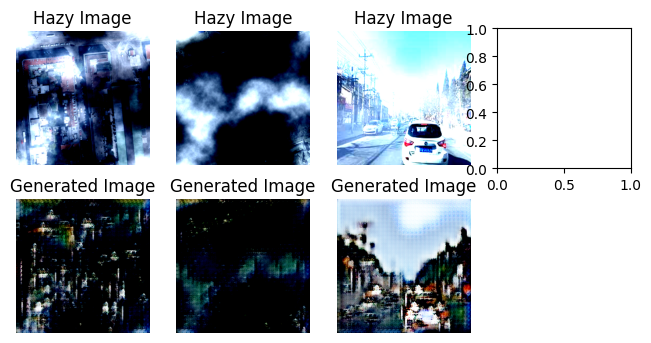

In [13]:
generated_images = generator(hazy_imgs[:num_samples]).detach().cpu()

plt.figure(figsize=(10, 4))
for i in range(num_samples):
    plt.subplot(2, num_samples, i + 1)
    plt.imshow(hazy_imgs[i].permute(1, 2, 0))  # Assuming images are in CHW format
    plt.title('Hazy Image')
    plt.axis('off')

    plt.subplot(2, num_samples, num_samples + i + 1)
    plt.imshow(generated_images[i].permute(1, 2, 0))  # Assuming images are in CHW format
    plt.title('Generated Image')
    plt.axis('off')

plt.tight_layout()
plt.show()
            